In [2]:
import pandas as pd
import numpy as np

### Modeling perimeter

In [33]:
tconst = pd.read_parquet("../data/edited_data/datamart.db/tconst")

In [34]:
title_ratings = pd.read_parquet("../data/edited_data/datamart.db/title_ratings").set_index("tconst")

In [35]:
title_name_avg_ratings = pd.read_parquet("../data/edited_data/intermediate.db/title_name_avg_ratings")
title_genres_avg_ratings = pd.read_parquet("../data/edited_data/intermediate.db/title_genres_avg_ratings")
primary_title = pd.read_parquet("../data/edited_data/intermediate.db/primary_title")
title_budget = pd.read_parquet("../data/edited_data/intermediate.db/title_budget")

In [297]:
data = (
    tconst.set_index("tconst")
    .join(title_name_avg_ratings)
    .join(title_genres_avg_ratings)
    .join(title_budget)
    .join(primary_title)
    .join(title_ratings, how="inner")
)

In [298]:
data = data.drop(
    columns=[
        "numVotes",
        "title", 
        "titleType", 
        "Movie", 
        "titleBasicsFlag",
        "primaryTitle",
        "DomesticGross",
        "WorldwideGross"],
    axis=1
)

In [299]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277451 entries, tt0000038 to tt9916720
Data columns (total 11 columns):
averageRating_name      199591 non-null float64
numVotes_name           199591 non-null float64
averageRating_genres    277451 non-null float64
numVotes_genres         277451 non-null float64
ReleaseDate             3885 non-null datetime64[ns]
ProductionBudget        3978 non-null float64
nObs                    3978 non-null float64
nLetters                277451 non-null float64
nCapitalLetters         277451 non-null float64
nWords                  277451 non-null float64
averageRating           277451 non-null float64
dtypes: datetime64[ns](1), float64(10)
memory usage: 25.4+ MB


In [300]:
data.to_parquet("../data/edited_data/modeling/data")

### perimeter
#### discretisation of target variable

In [350]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [351]:
data = pd.read_parquet("../data/edited_data/modeling/data")
data = data.dropna()

In [391]:
mean_avg_ratings = np.median(data.averageRating)
data["target"] = pd.cut(data.averageRating, bins=4, labels=False)
#(data.averageRating >= mean_avg_ratings).astype(int)

In [392]:
data["releaseMonth"] = data["ReleaseDate"].dt.month

### explanatory
#### correlations

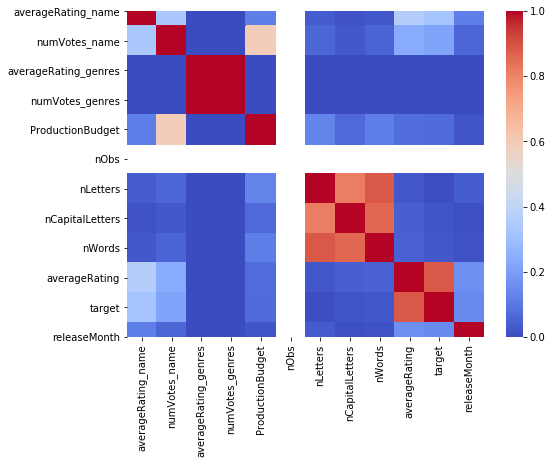

In [393]:
corr = np.abs(data.corr())

fig = plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="coolwarm")

dropped columns after correlation analysis

In [394]:
cols_drop = [
    "numVotes_name", 
    "averageRating",
    "nLetters", 
    "nCapitalLetters", 
    "averageRating_genres", 
    "numVotes_genres", 
    "nObs", 
    "ReleaseDate"
]

### modeling

In [395]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [396]:
perimeter = data.drop(columns=cols_drop, axis=1)

In [397]:
X = perimeter.drop(columns=["target"], axis=1)
y = perimeter.target

In [398]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12345)

In [399]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

In [400]:
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [401]:
y_pred = clf.predict(X_test_scaled)

In [402]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00       176
           2       0.65      1.00      0.79       725
           3       0.43      0.02      0.03       191

    accuracy                           0.65      1112
   macro avg       0.27      0.25      0.21      1112
weighted avg       0.50      0.65      0.52      1112



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [403]:
contributions = dict(zip(X.columns.tolist(), np.abs((np.std(X_train_scaled, 0) * clf.coef_)[0])))

In [390]:
pd.DataFrame.from_dict(contributions, orient="index").sort_values(by=0, ascending=False)

,0
averageRating_name,0.569096
ProductionBudget,0.540299
releaseMonth,0.376159
nWords,0.035828
